# TrackSubtract 
Automatic removal of copyrighted music from audio streams.

2018.06.07 MPKT

## Goal
Most major video-sharing platforms scan content for copyrighted audio. When infringing audio is detected in the background of a file, it is either deleted or muted. Either option results in fewer files, less revenue, and frustrated users. TrackSubtract provides a one-click product for removing unwanted copyrighted music from any audio file.

## Algorithm
A user submits an audiofile labeled `Mixed` that contains both the desired audio and a undesirable background song.
-  A music identification service (such as the open-source EchoPrint) identifies the song track in the background
-  A file containing labeled `UndesiredTrue` is obtained, containing a clean version.
-  Signal correlation between the `Mixed` and `UndesiredTrue` is calculated as a function of lag time to identify the temporal offset.
-  A sliding correction window (in the time domain) will scan over the song to match the amplitude of `UndesiredTrue` to `Mixed` before subtraction, since this will vary over the course of the recording. Thus the pre-subtraction signal attenuation factor (*A*) is empirically determined as a function of time.
-  In real situations, the attenuation will not be consistent across all frequencies (trivial example: music that was accidentally recorded while being played from a phone speaker will not contain the bass frequencies that are present in `UndesiredTrue`). Consequently, it may be helpful to pass a sliding frequency window within the sliding time window. In this case, the pre-subtraction signal attenuation (*A*) is a calculated as a function of time and frequency.
-  The `UndesiredTrue` is waveform is inverted, scaled by *A*, and added to `Mixed`.

## Quick Eqns
Only taking into account the temporal offset, this can be conceptualized as: `Mixed(t) = Signal(t) + A*Song(t+temporalOffset)`, thus, `Signal(t) = SignalAndSong(t) - A*Song(t+temporalOffset)`

Taking into account (by sliding windows) that the attenuation is a function of both time and frequency: `Signal(t,f) = SignalAndSong(t,f) - *A(t,f)*\*Song(t+temporalOffset,f)`

## Data
The `UndesiredTrue` file contains a recording of the song "Hey" from the BenSound.com royalty-free audio website.

The `Mixed` file contains a recording of me talking, while "Hey" plays in the background.

## ChangeLog
-  v4 works, with alignment over whole spectrum
-  v5 switching to functionfor alignment & padding

# Preparation

## Settings

In [1]:
# Filenames
Mixed_Filename = 'SongAndSignal.wav';
Undesired_True_Filename = 'SongTrue_MONO_Short.wav';

# Set time range in seconds, if working with subset
# Set to 0 to use the entire file
TrimMixed_s1_s2 = (5,7)
TrimUndesiredTrue_s1_s2 = (5.1,7.1)

# Set absolute value of maximum lag if known (seconds)
max_lag_s = 0.45

# Verbosity (0/1)
qVerbose = 2; # 1= text feedback, 2 = plot feedback
qSillyWaveformSubtraction = 0; # show nonsense attempt to subtract waveforms

## Import necessary libraries

In [2]:
from scipy.io.wavfile import read as wavread # import files
import matplotlib.pyplot as plt 
import numpy as np
import operator # for finding max values
import seaborn as sns # for the Pxx heatmaps

## Disable auto-scroll

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the files

In [4]:
# actual import
UndesiredTrueRate, UndesiredTrueTimeseries = wavread(Undesired_True_Filename)
MixedRate, MixedTimeseries = wavread(Mixed_Filename)

# Trim the files, if requested
if TrimMixed_s1_s2 != 0:
    MixedTimeseries = MixedTimeseries[(round(MixedRate*TrimMixed_s1_s2[0])):(round(MixedRate*TrimMixed_s1_s2[1]))]
if TrimUndesiredTrue_s1_s2 != 0:
    UndesiredTrueTimeseries = UndesiredTrueTimeseries[(round(UndesiredTrueRate*TrimUndesiredTrue_s1_s2[0])):(round(UndesiredTrueRate*TrimUndesiredTrue_s1_s2[1]))]

# Visual exploration

## Define plotting function

In [5]:
def plot_two_timeseries(X_mixed, X_undesired, SamplingRate):
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    ax.set_title('Mixed signal')
    Pxx_mixed, freqs_mixed, bins_mixed, im_mixed = plt.specgram(X_mixed, NFFT=1024, Fs=SamplingRate, noverlap=900,cmap='gnuplot2')

    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111)
    ax.set_title('Undesired signal')
    Pxx_undesired, freqs_undesired, bins_undesired, im_undesired = plt.specgram(X_undesired, NFFT=1024, Fs=SamplingRate, noverlap=900,cmap='gnuplot2')


    print('X_mixed size = ' + str(X_mixed.size))
    print('Track len = ' + str(round(X_mixed.size/SamplingRate,2))+ ' s')
    print('Pxx size = ' + str(Pxx_mixed.size))
    print('freqs size = ' + str(freqs_mixed.size))
    print('bins size = ' + str(bins_mixed.size))
    print('---------------------------------')

    print('X_to_align size = ' + str(X_undesired.size))
    print('Track len = ' + str(round(X_undesired.size/SamplingRate,2))+ ' s')
    print('Pxx size = ' + str(Pxx_undesired.size))
    print('freqs size = ' + str(freqs_undesired.size))
    print('bins size = ' + str(bins_undesired.size))
    
    return (Pxx_mixed, freqs_mixed, bins_mixed, im_mixed), (Pxx_undesired, freqs_undesired, bins_undesired)

## Plot the input timeseries

X_mixed size = 88200
Track len = 2.0 s
Pxx size = 361152
freqs size = 513
bins size = 704
---------------------------------
X_to_align size = 88200
Track len = 2.0 s
Pxx size = 361152
freqs size = 513
bins size = 704


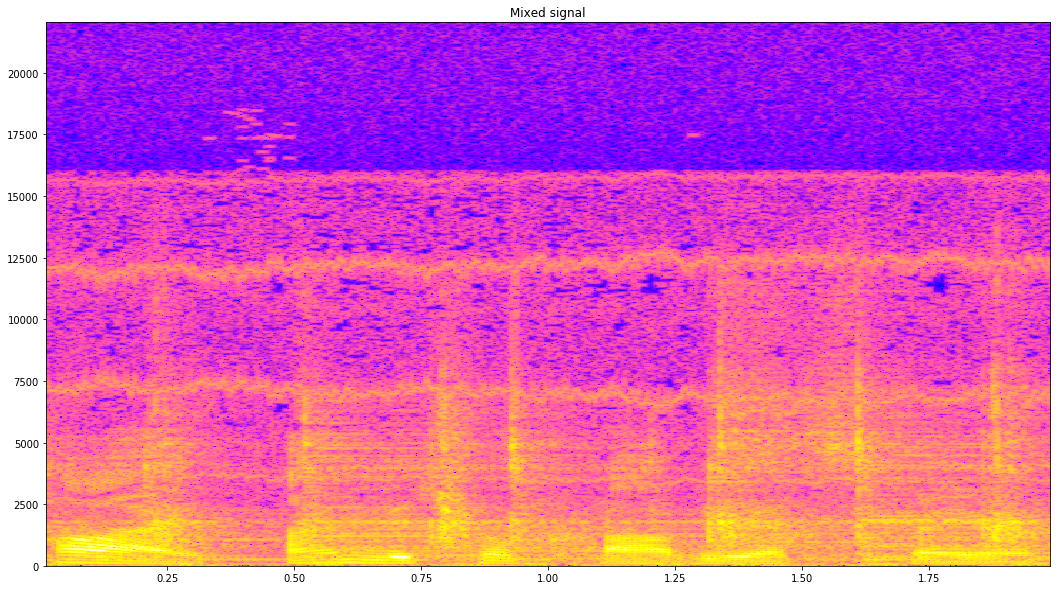

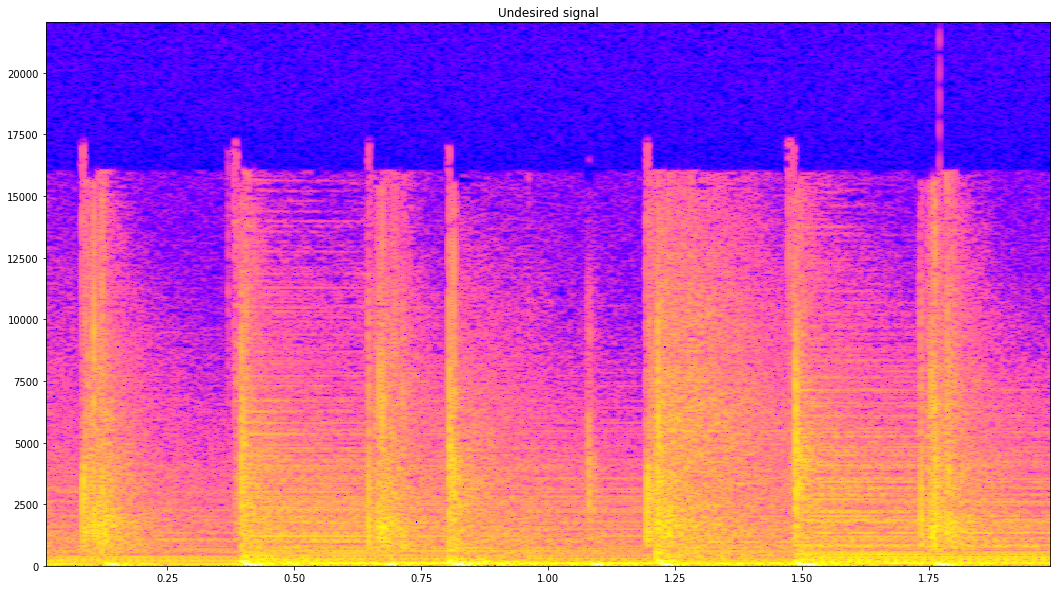

In [13]:
plot_two_timeseries(MixedTimeseries, UndesiredTrueTimeseries, MixedRate);

# Signal processing: identify temporal offset

## Define lagcorr (prelim)

From https://stackoverflow.com/questions/9382207/specify-lag-in-numpy-correlate

Added `()`'s around print to update to python 3

In [7]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

## Define alignment and padding function

In [8]:
def align_timeseries(  X_stationary, X_to_align, SamplingRate, max_lag_s, qVerbose  ):
    
    padwidth = len(X_to_align)-len(X_stationary);

    if qVerbose > 0:
        print('X_to_align original length = ' + str(len(X_to_align)))
        print('X_stationary original length = ' + str(len(X_stationary)))           
        print('Padding Adjustment = ' + str(padwidth))

    if padwidth < 0: 
        # mixed is longer than undesired; pad the song
        X_to_align = np.pad(X_to_align, abs(padwidth), 'constant')
        X_to_align = X_to_align[range(0, len(X_to_align)-abs(padwidth))]

    elif padwidth > 0:
        # undesired is longer than mixed; pad the mix
        X_stationary = np.pad(X_stationary, padwidth, 'constant')
        MixedSongTimeseries = MixedSongTimeseries[range(0, len(MixedSongTimeseries)-padwidth)]

    if qVerbose > 0:
        print('X_to_align length = ' + str(len(X_to_align)))
        print('X_stationary length = ' + str(len(X_stationary)))
        
    max_lag_N_inds =round(max_lag_s*SamplingRate); # convert from s to frames
    lag_ana = lagcorr(UndesiredTrueTimeseries,MixedTimeseries,verbose=True, lag = max_lag_N_inds)
    lag_kata = lagcorr(UndesiredTrueTimeseries,MixedTimeseries,verbose=True, lag = -max_lag_N_inds)
    
    # combine results
    bidirectional_corr_coeffs = np.concatenate((lag_kata[::-1,0], lag_ana[:,0]))
    bidirectional_p_values = np.concatenate((lag_kata[::-1,1], lag_ana[:,1]))
    lag_timebase_frames = [i-max_lag_N_inds for i in range(max_lag_N_inds)]+[0, 0]+[i for i in range(max_lag_N_inds)]
    lag_timebase_s = [i/max_lag_N_inds for i in lag_timebase_frames]

    # find max correlation
    max_cc_index, max_cc_value = max(enumerate(bidirectional_corr_coeffs), key=operator.itemgetter(1))
    max_cc_s = lag_timebase_s[max_cc_index]
    max_cc_indshift = round(max_cc_index-len(lag_timebase_s)/2);
    cc_std = np.std(bidirectional_corr_coeffs)
    cc_mean = np.mean(bidirectional_corr_coeffs)

    # Give text information about the fit, if qVerbose >= 1
    if qVerbose >= 1:
        print('**********************************')
        if max_cc_s < 0:
            print('Mix lags behind undesired true')
        elif max_cc_s > 0:
            print('Mix ahead of undesired true')
        print('Temporal offset = '+str(round(max_cc_s,5))+' s (ind ',str(max_cc_indshift),')')
        print('@ max correlation coeff = '+str(round(max_cc_value,2)))
        print('which is ', str(round((max_cc_value-cc_mean)/cc_std,1)), ' stddev above mean')
        print('  (correlation mean:',str(round(cc_mean,5)),')')
        print('  (correlation stddev:',str(round(cc_std,5)),')')
        
    # Show plots for the offset, if qVerbose >= 2
    if qVerbose >= 2:
        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(111)    # The big subplot
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)

        # Turn off axis lines and ticks of the big subplot
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

        ax1.plot(lag_timebase_s,bidirectional_corr_coeffs)
        ax2.plot(lag_timebase_s,bidirectional_p_values)

        # Set common labels
        ax.set_xlabel('offset (sec)')
        ax1.set_ylabel('correlation coefficient')
        ax2.set_ylabel('p-value')

        ax1.set_title('Identify temporal offset')

       # plt.savefig('common_labels.png', dpi=300)
    
    
    ## Perform the time shift
    shift_by_inds = abs(max_cc_indshift)

    if max_cc_indshift < 1:
        #the undesired signal is ahead of the recording: so then pad the front of the undesired with zeroes and chop off the bac
        X_aligned = np.pad(X_to_align, shift_by_inds, 'constant')
        X_aligned = X_aligned[0:(len(X_aligned)-shift_by_inds*2)]


    elif max_cc_indshift > 1:
        # converse
        pass
    
    return X_aligned, max_cc_s

    
    ## if qVerbose >= 3, show the aligned spectral plots
    if qVerbose >= 9999: 
        fig = plt.figure(figsize=(18,10))
        ax = fig.add_subplot(111)
        ax.set_title('Mixed signal')
        Pxx_stationary, freqs_stationary, bins_stationary, im_stationary = plt.specgram(X_stationary, NFFT=1024, Fs=SamplingRate, noverlap=900,cmap='gnuplot2')

        fig = plt.figure(figsize=(18,10))
        ax = fig.add_subplot(111)
        ax.set_title('True undesired signal, aligned')
        Pxx_aligned, freqs_aligned, bins_aligned, im_aligned = plt.specgram(X_aligned, NFFT=1024, Fs=SamplingRate, noverlap=900,cmap='gnuplot2')


        print('X_stationary size = ' + str(X_stationary.size))
        print('Pxx size = ' + str(Pxx_stationary.size))
        print('freqs size = ' + str(freqs_stationary.size))
        print('bins size = ' + str(bins_stationary.size))
        print('---------------------------------')

        print('X_to_align size = ' + str(X_aligned.size))
        print('Pxx size = ' + str(Pxx_aligned.size))
        print('freqs size = ' + str(freqs_aligned.size))
        print('bins size = ' + str(bins_aligned.size))
        


## Coarse alignment

### Prep vars for clarity

In [15]:
X_stationary = MixedTimeseries;
X_to_align = UndesiredTrueTimeseries;
SamplingRate = MixedRate;
qVerbose = 2;

### Perform the actual alignment

X_to_align original length = 88200
X_stationary original length = 88200
Padding Adjustment = 0
X_to_align length = 88200
X_stationary length = 88200

#<lagcorr>: Computing lagged-correlations at lags: [    0     1     2 ..., 19843 19844 19845]

#<lagcorr>: Computing lagged-correlations at lags: [     0     -1     -2 ..., -19843 -19844 -19845]
**********************************
Mix lags behind undesired true
Temporal offset = -0.27166 s (ind  -5392 )
@ max correlation coeff = 0.1
which is  6.2  stddev above mean
  (correlation mean: 4e-05 )
  (correlation stddev: 0.0166 )


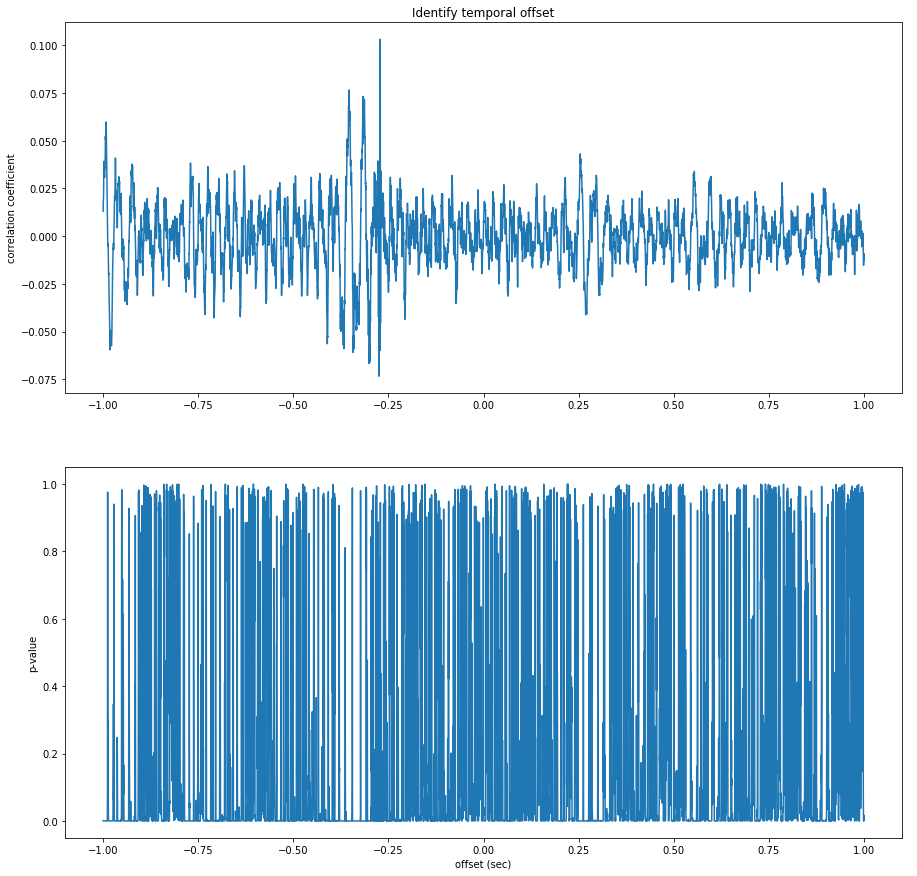

In [10]:
UndesiredTrueTimeseries_aligned, max_cc_s = align_timeseries(  X_stationary, X_to_align, SamplingRate, max_lag_s, qVerbose  )

### Plot the alignment, and extract spectral data

/home/m/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


X_mixed size = 88200
Track len = 2.0 s
Pxx size = 361152
freqs size = 513
bins size = 704
---------------------------------
X_to_align size = 88200
Track len = 2.0 s
Pxx size = 361152
freqs size = 513
bins size = 704


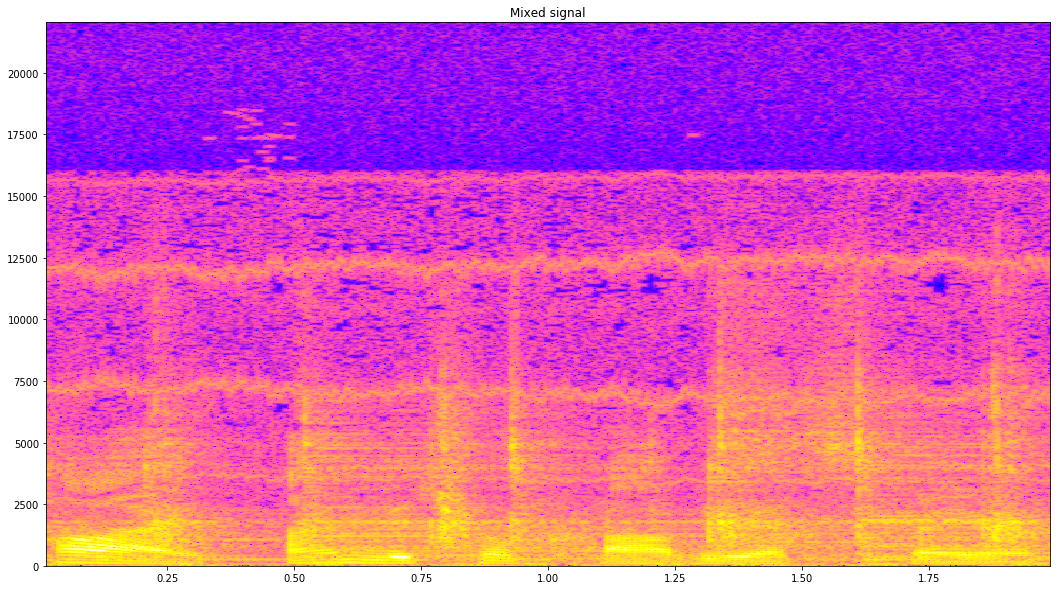

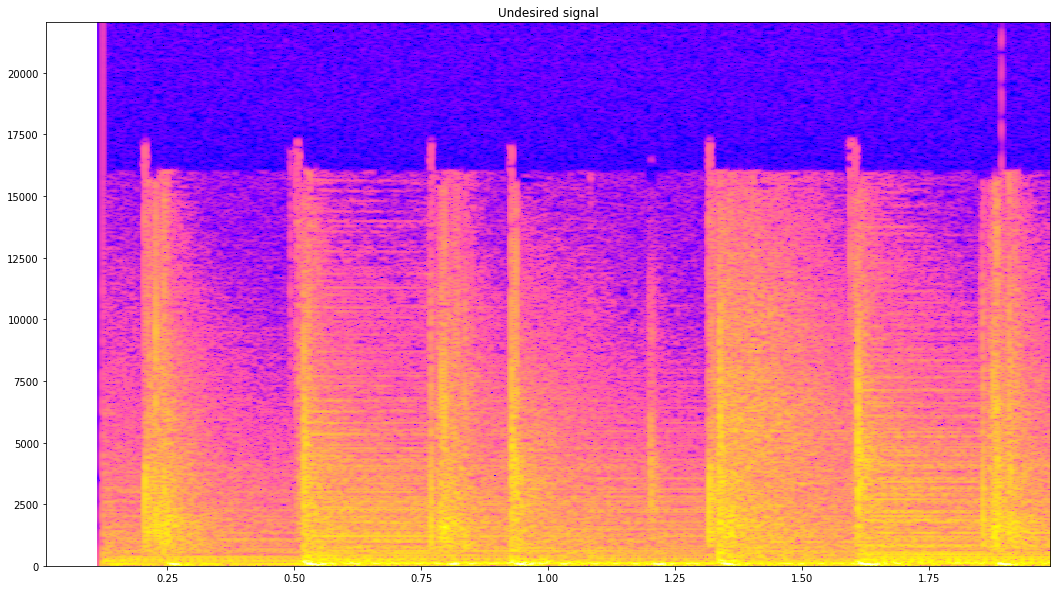

In [11]:
MixedOut, UndesiredOut = plot_two_timeseries(MixedTimeseries, UndesiredTrueTimeseries_aligned, MixedRate)

Pxx_mixed = MixedOut[0]
freqs_mixed = MixedOut[1]
bins_mixed = MixedOut[2]
Pxx_undesired = UndesiredOut[0]
freqs_undesired = UndesiredOut[1]
bins_undesired = UndesiredOut[2]

# Practice: Plot the spectral representation on its own

Note, I do not have an automatic adjustment for vmax yet. They are set arbitrarily

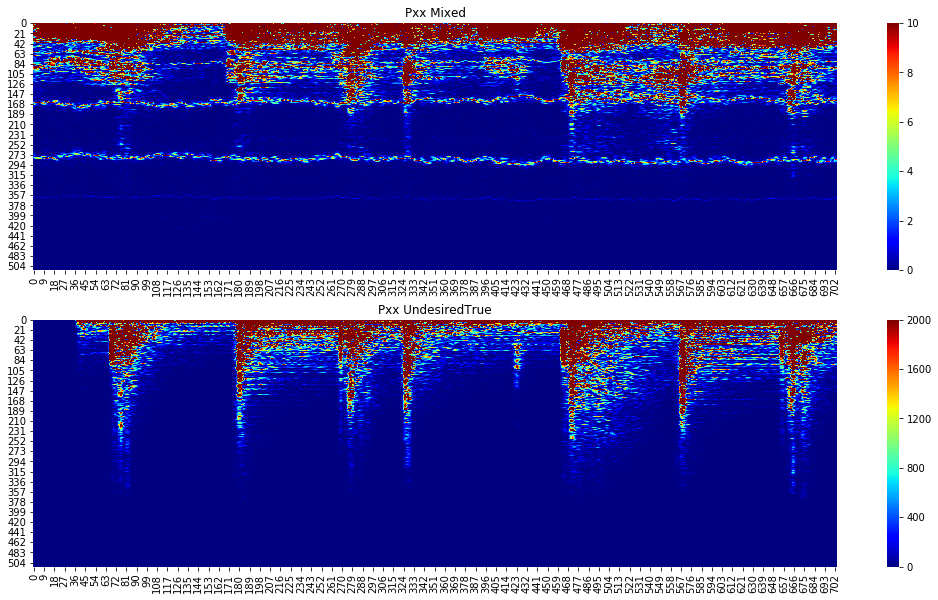

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(211)
ax.set_title('Pxx Mixed')
ax = sns.heatmap(Pxx_mixed,vmin=0, vmax=10, cmap='jet')

ax = fig.add_subplot(212)
ax.set_title('Pxx UndesiredTrue')
ax = sns.heatmap(Pxx_undesired,vmin=0, vmax=2000, cmap='jet')

